In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import pandas as pd
import astropy as ap
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from datetime import datetime
import seaborn as sns

from importlib import reload

import sys, os
sys.path.append('/home/apizzuto/Nova/scripts/')
import plotting

import histlite as hl
import csky as cy

from glob import glob
mpl.style.use('/home/apizzuto/Nova/scripts/novae_plots.mplstyle')

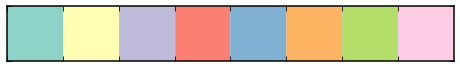

In [3]:
sns.palplot(sns.color_palette("Set3", 8))

In [43]:
reload(plotting)

<module 'plotting' from '/home/apizzuto/Nova/scripts/plotting.py'>

In [6]:
stack_plots = plotting.StackingPlots(86400., seed=2, min_log_e=0.0)

In [7]:
stack_plots.get_all_sens()

In [7]:
counter = 0
allcounter = 0
for allflavor_str in [True, False]:
    for deltaT in np.append(np.logspace(-3., 1., 9)[:]*86400., np.array([86400.*5.])):
        for gamma in [2.0, 2.5, 3.0]:
            for cut in [0.0, 0.5, 1.0]:
                file_str = "/data/user/apizzuto/Nova/csky_trials/stacking_sens_res/signal_results/" \
                       + f"delta_t_{deltaT:.2e}_gamma_{gamma}_minLogE_{cut}_allflavor_{allflavor_str}.pkl"
                if not os.path.exists(file_str):
                    print(allflavor_str, deltaT, gamma, cut)
                    counter += 1
                allcounter += 1
print(allcounter, counter)

True 864000.0 3.0 0.0
True 864000.0 3.0 1.0
180 2


Setting up Analysis for:
GRECOv2.4
Setting up GRECOv2.4...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.
          gamma
     4.0000e+00
Done.
-0.0 0.0 1.0


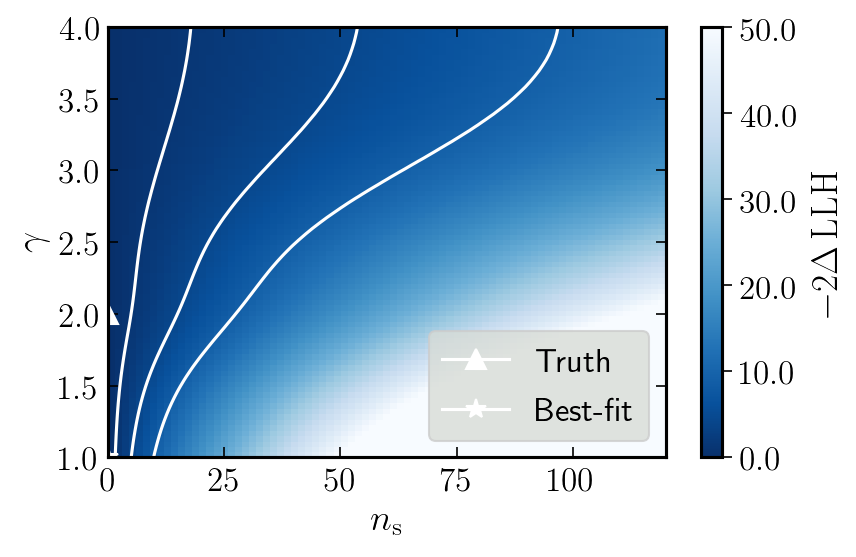

In [8]:
# TRY COLOR SCALE RdGy
stack_plots.set_seed(13467)
stack_plots.likelihood_scan(n_inj=0.)

In [38]:
tr = cy.get_trial_runner(stack_plots.conf, ana=stack_plots.ana, src=stack_plots.src, 
                    inj_conf={'flux': cy.hyp.PowerLawFlux(2.0)})
trial = tr.get_one_trial(n_sig=50, TRUTH=False, seed=1,
            poisson=False)

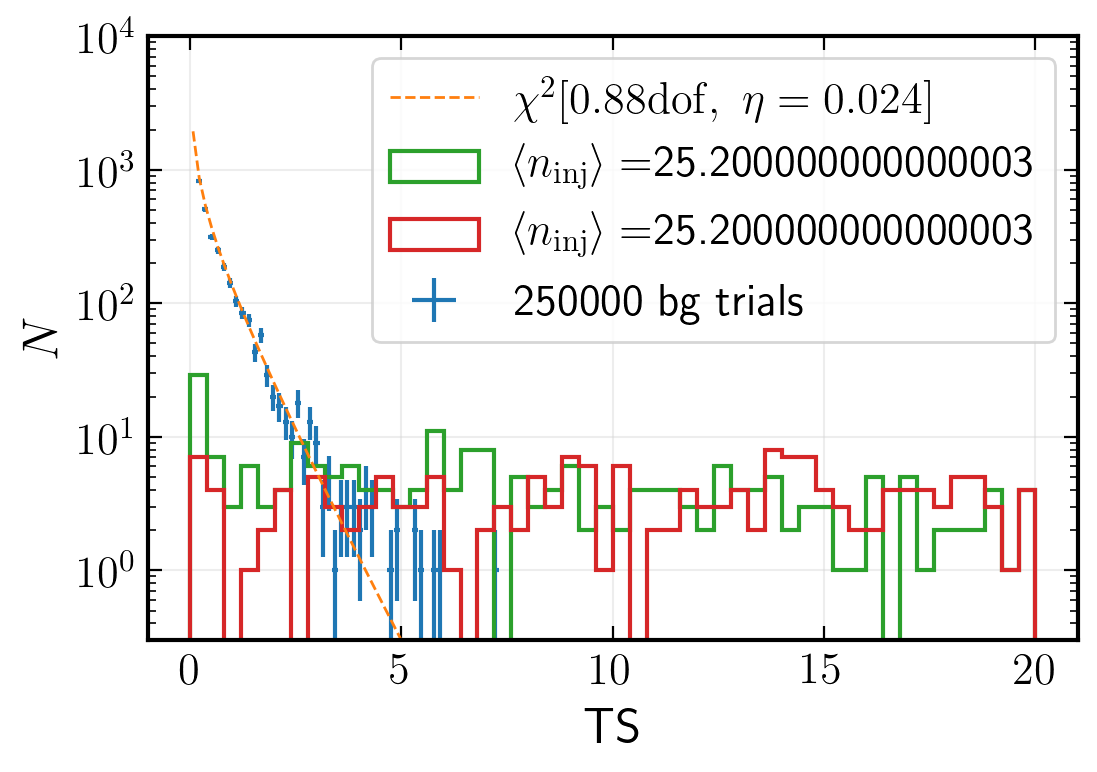

In [9]:
stack_plots.sensitivity_plot()

In [10]:
stack_plots.names

0              V2677 Oph
1              V5593 Sgr
2              V3666 Oph
3              V3662 Oph
4               V612 Sct
5              V5855 Sgr
6              V1663 Sco
7              V1662 Sco
8               V959 Mon
9              V1724 Aql
10             V2659 Cyg
11             V1660 Sco
12             V5667 Sgr
13              V962 Cep
14             V5857 Sgr
15             V5852 Sgr
16              V392 Per
17    OGLE-2011-BLG-1444
18             V1534 Sco
19             V5592 Sgr
20             V1656 Sco
21             V1405 Cen
22             V1657 Sco
23             V1830 Aql
24     OGLE-2013-NOVA-04
25             V1661 Sco
26             V1533 Sco
27             V5856 Sgr
28             V3665 Oph
29             V5854 Sgr
             ...        
37              V611 Sct
38              V556 Nor
39             V5853 Sgr
40             V1369 Cen
41             V1658 Sco
42              V906 Car
43             V3664 Oph
44             V1831 Aql
45              V339 Del


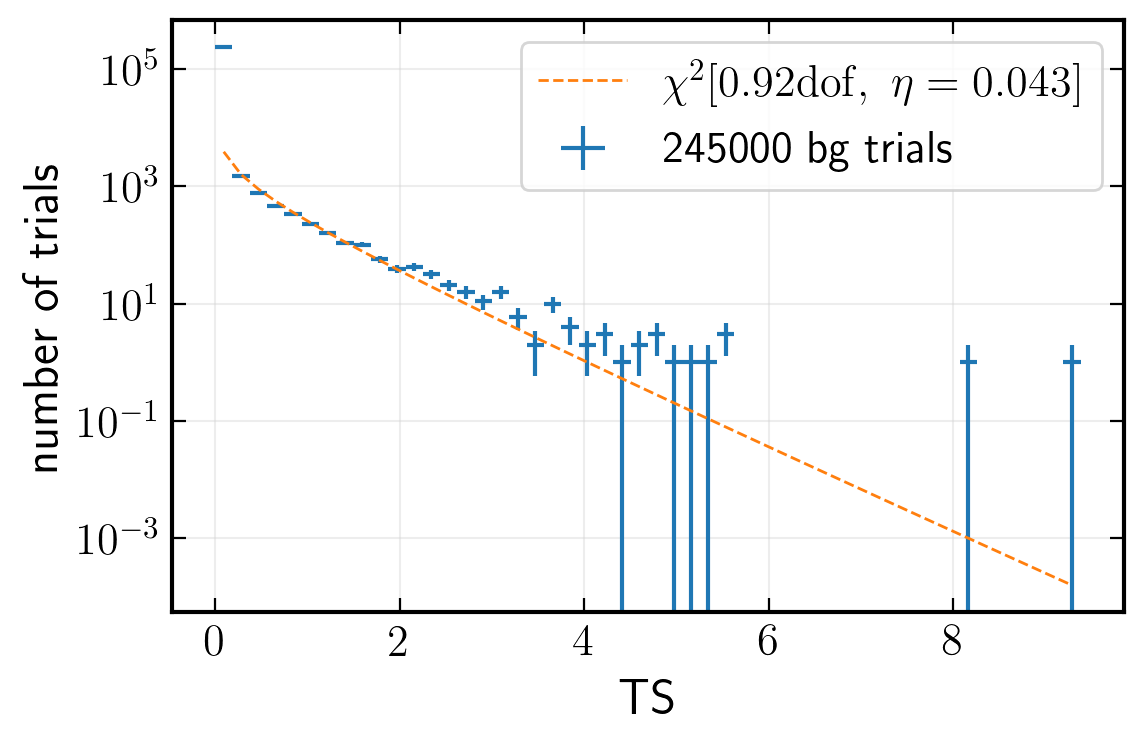

In [26]:
stack_plots.background_distribution()

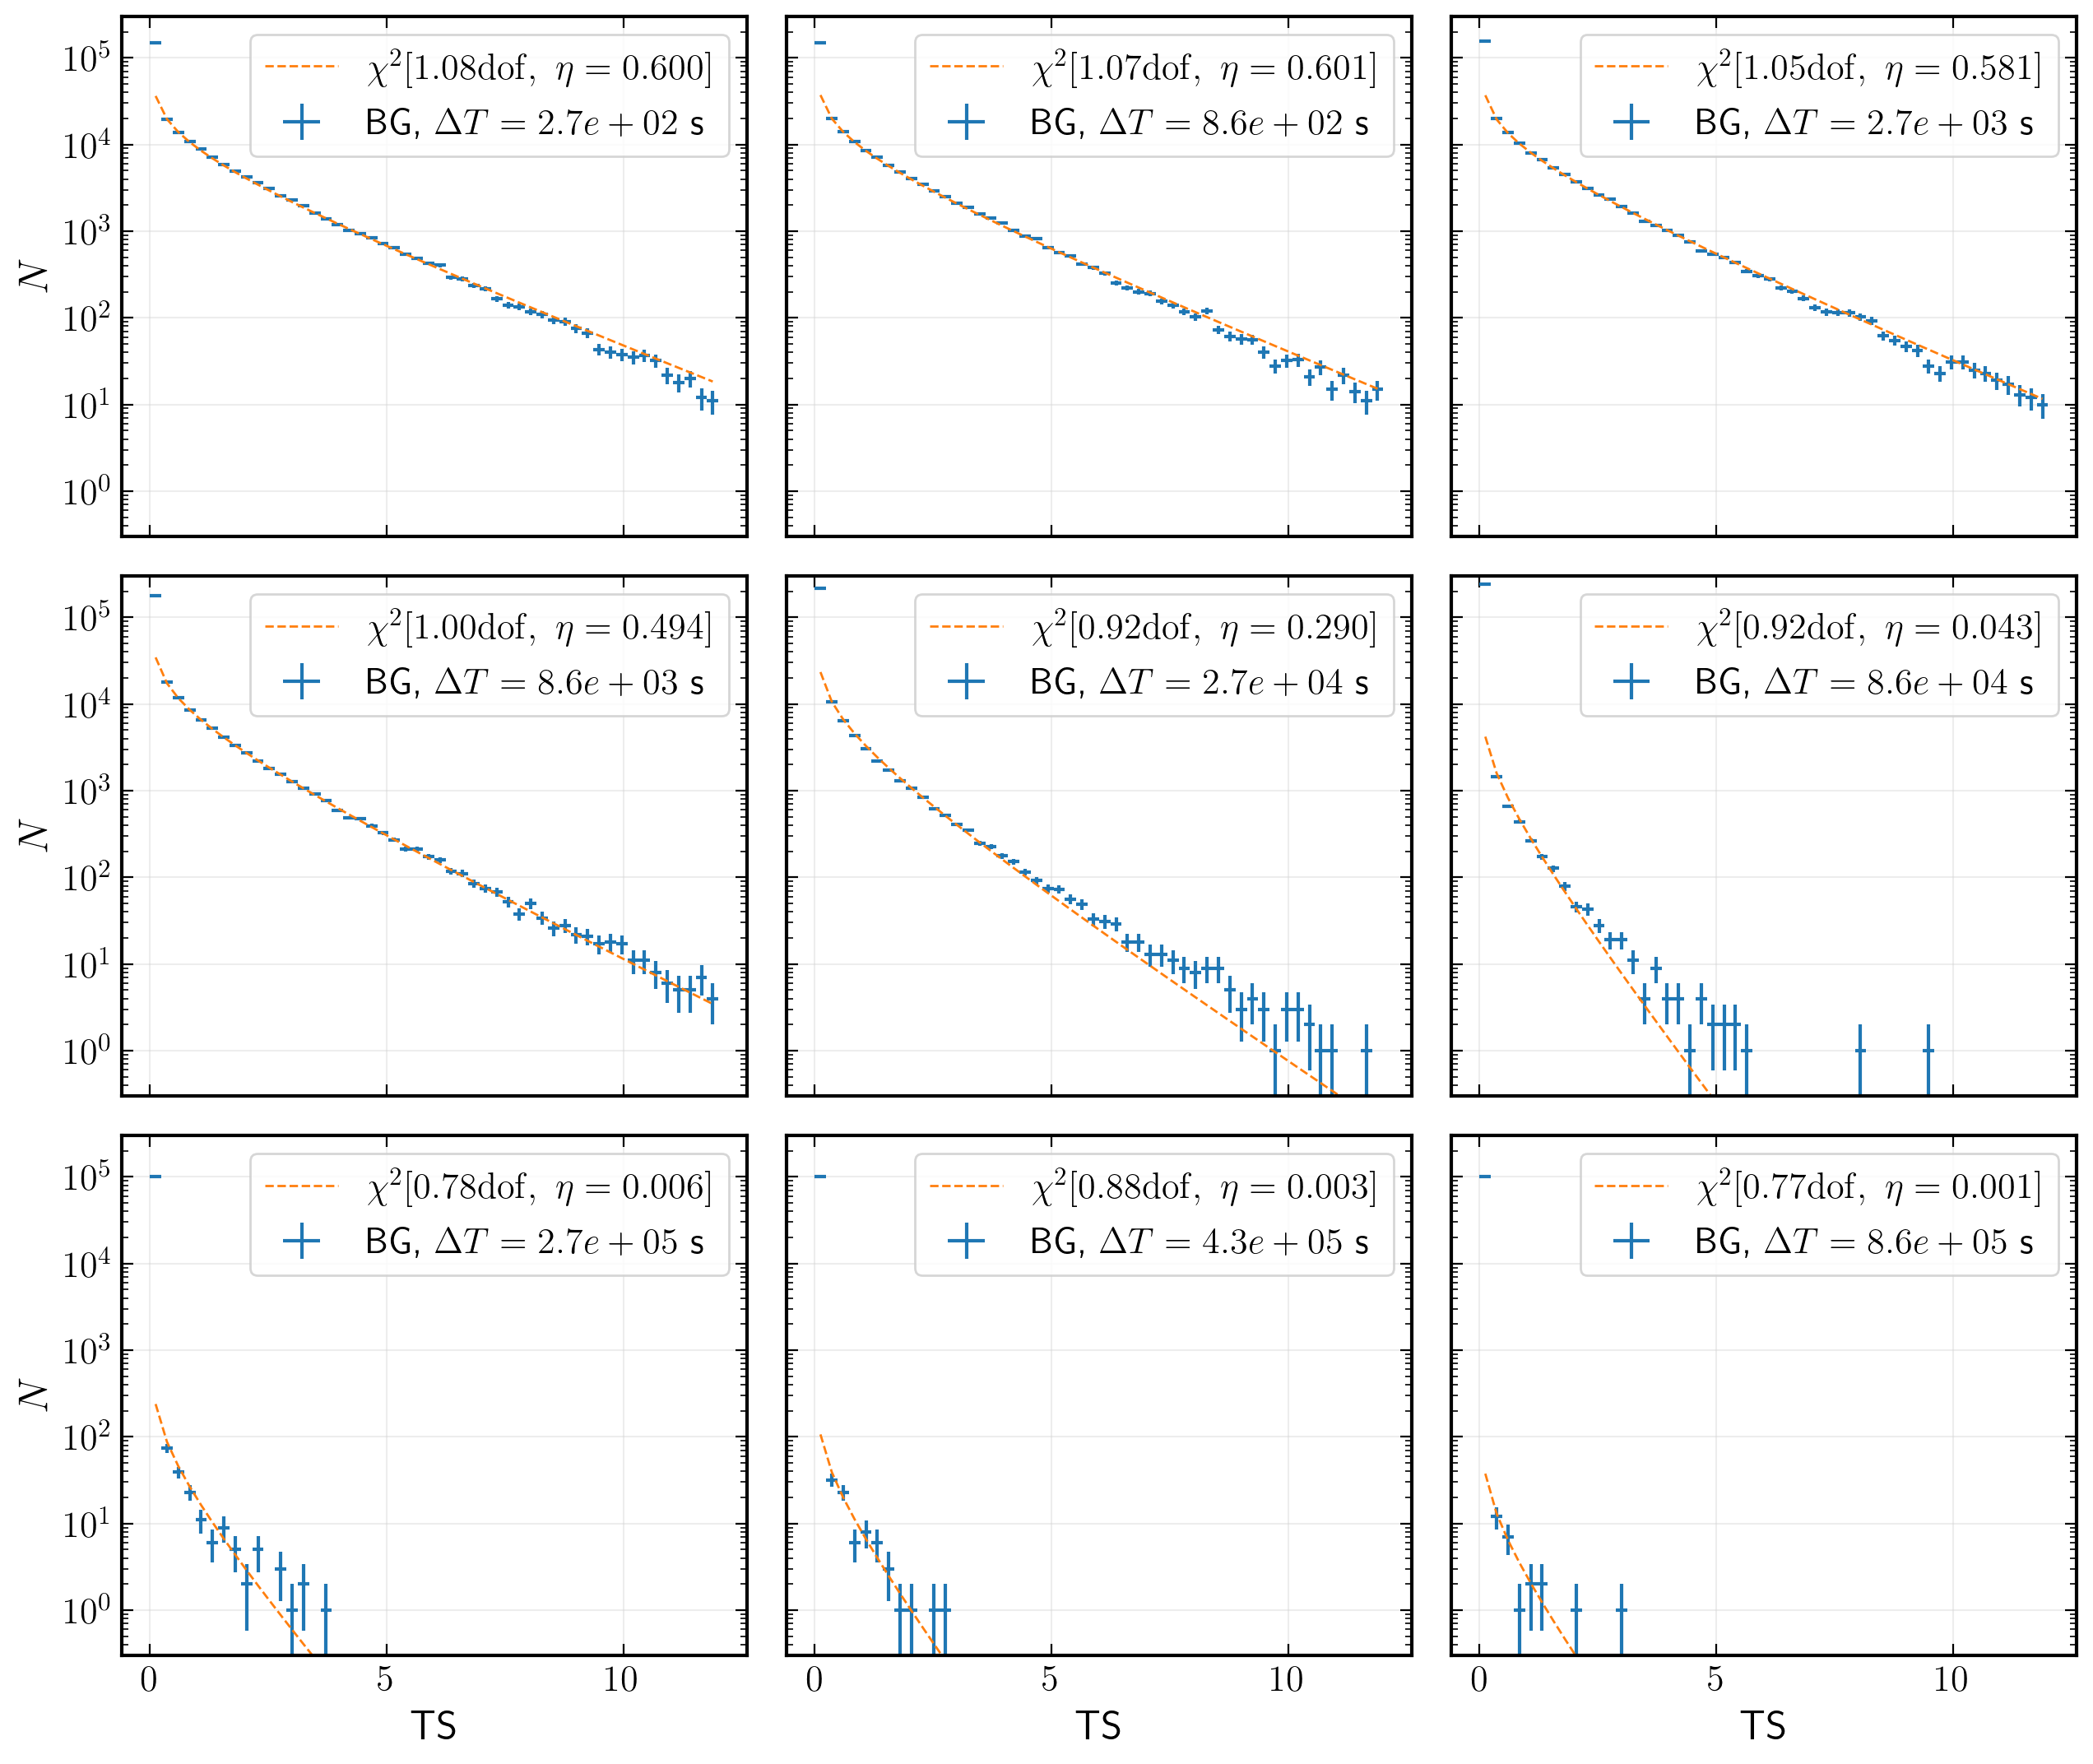

In [27]:
stack_plots.background_vs_time()

In [29]:
stack_plots.set_seed(8)

          gamma
     4.0000e+00
Done.
48.92863584414917 66.83544303797468 2.1392405063291138


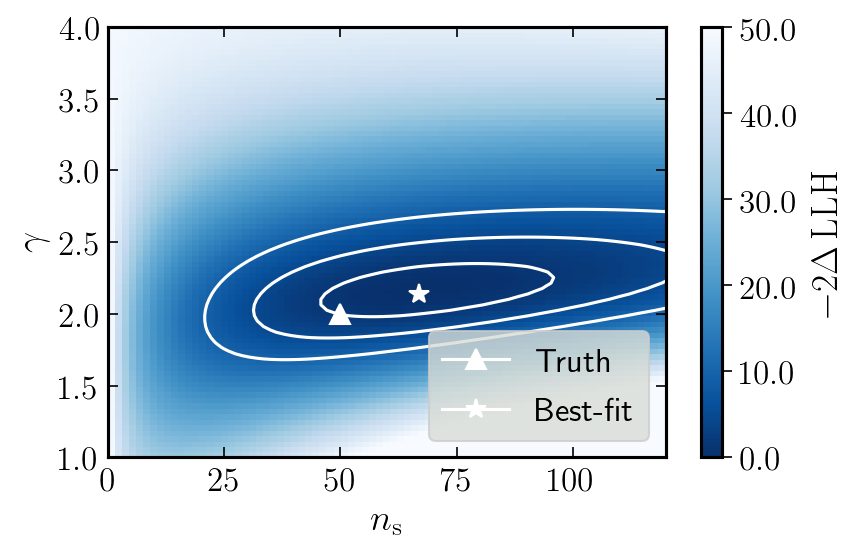

In [30]:
stack_plots.likelihood_scan(n_inj=50., inj_gamma=2.0, truth=False)

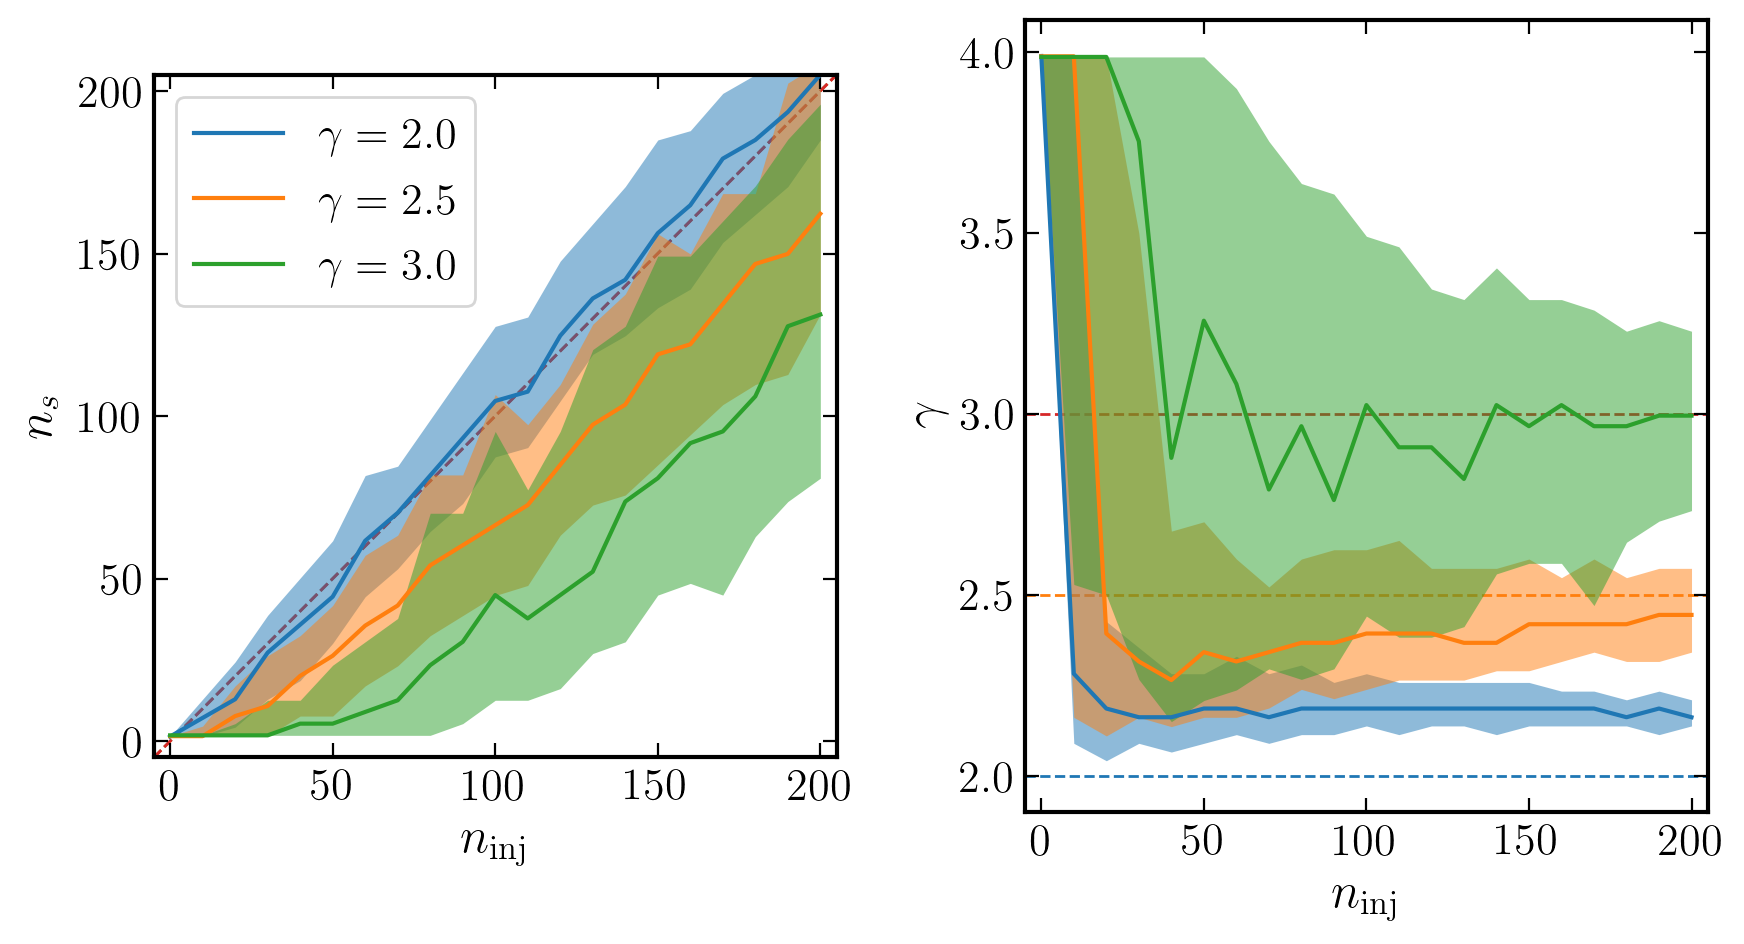

In [21]:
stack_plots.fitting_plot(gamma=[2.0, 2.5, 3.])

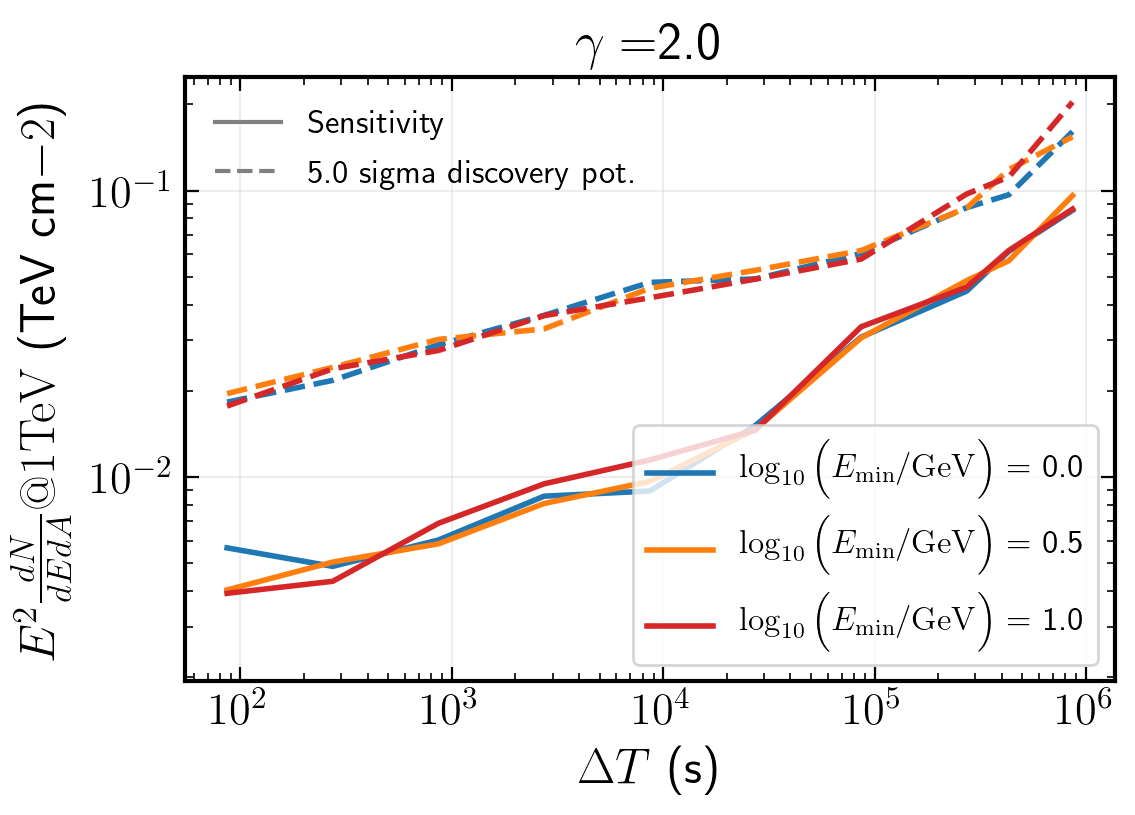

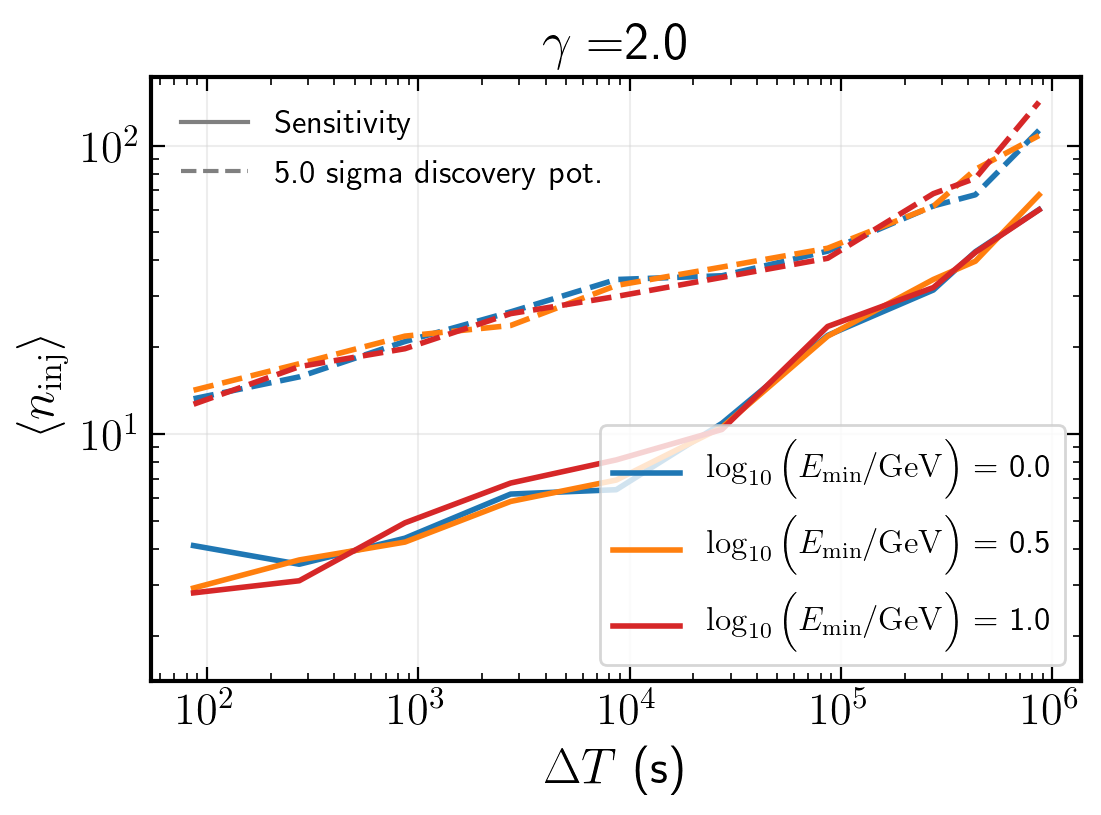

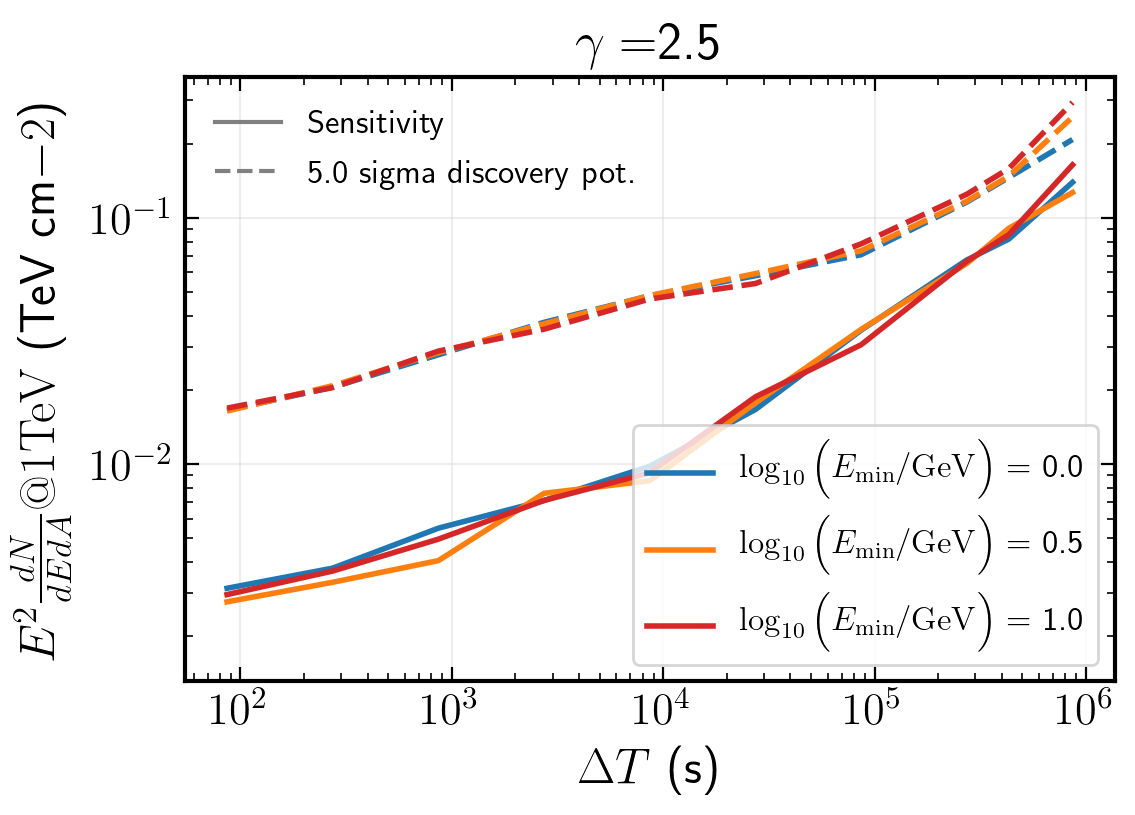

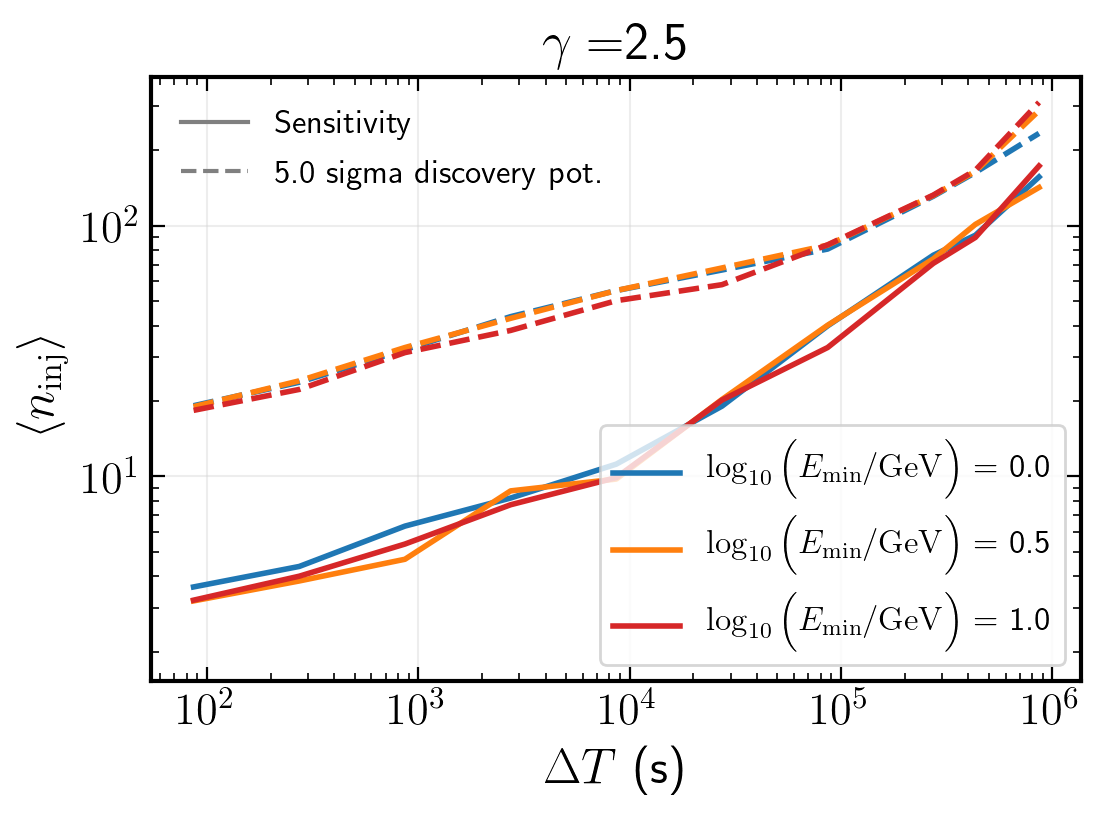

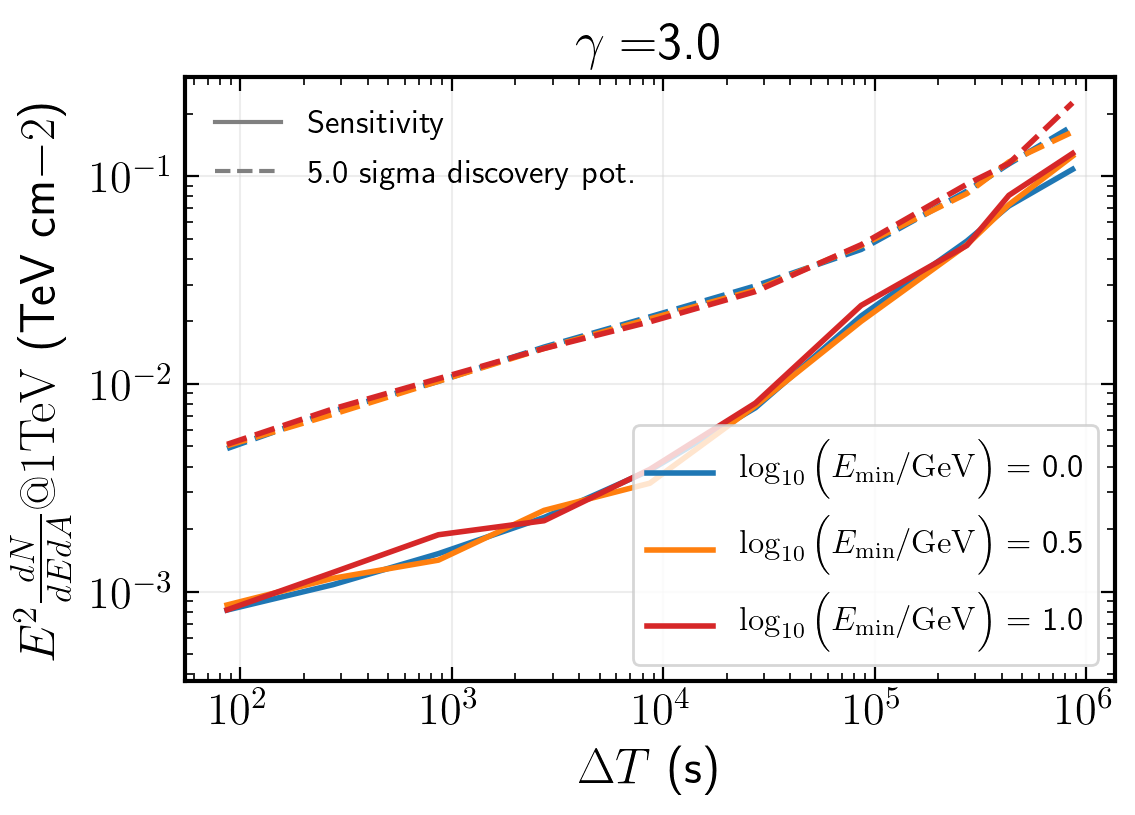

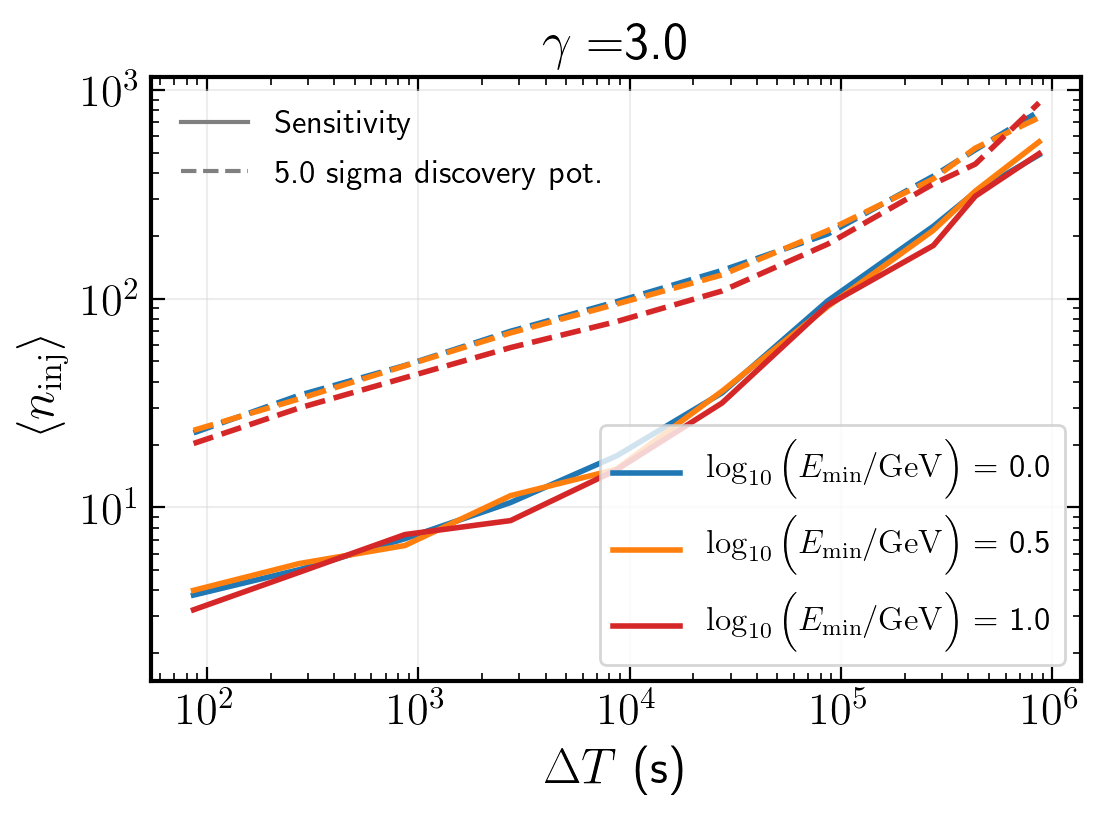

In [28]:
reload(plotting)
for gam in [2.0, 2.5, 3.0]:
    for in_flux in [True, False]:
        fig, ax = plt.subplots(dpi=200)
        for min_log in [0.0, 0.5, 1.0]:
            try:
                stack_plots = plotting.StackingPlots(86400., seed=2, min_log_e=min_log)
                stack_plots.get_all_sens()
                show = True if min_log == 1.0 else False
                stack_plots.plot_sensitivity_vs_time(gamma=gam, ax=ax, show=show, 
                            with_discovery=True, in_flux=in_flux)
            except:
                pass

In [29]:
stack_plots = plotting.StackingPlots(86400., seed=2, min_log_e=0.0)
stack_plots.get_all_sens()

In [32]:
stack_plots.get_this_sens()
stack_plots.sensitivity[2.0]['E2dNdE']

0.030817730828747256

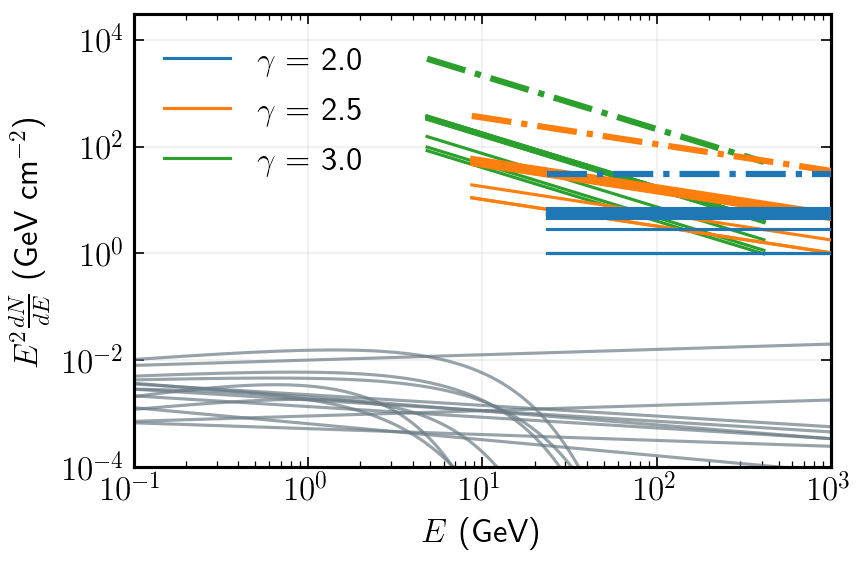

In [49]:
stack_plots = plotting.StackingPlots(86400., seed=2, min_log_e=0.0)
stack_plots.get_all_sens()

cat = plotting.GammaCatalog(verbose = True)
cat.compare_photon_to_nus(delta_t = 1e5, omit_title=True)

ens = np.logspace(-1., 3., 500)
gam_cols = {2.0: 'C0', 2.5: 'C1', 3.0: 'C2'}

for gamma in [2.0, 2.5, 3.0]:
    sens = stack_plots.sensitivity[gamma]['E2dNdE']
    central_90_energies = cat.central_90[gamma]
        
    nu_sens_spec = np.power(ens, -gamma)*sens*1e3*(1e-3)**(2.-gamma)
    en_msk = (ens > central_90_energies[0]) & (ens < central_90_energies[1])
    plt.plot(ens[en_msk], nu_sens_spec[en_msk]*ens[en_msk]**2,
           color=gam_cols[gamma], lw = 3.0, zorder=5*(5.-gamma), ls='-.')

In [33]:
stack_plots.sensitivity[2.0].keys()

dict_keys(['n_sig', 'n_sig_error', 'n_sig_history', 'n_sig_error_history', 'n_trials_history', 'info', 'tss', 'E2dNdE'])

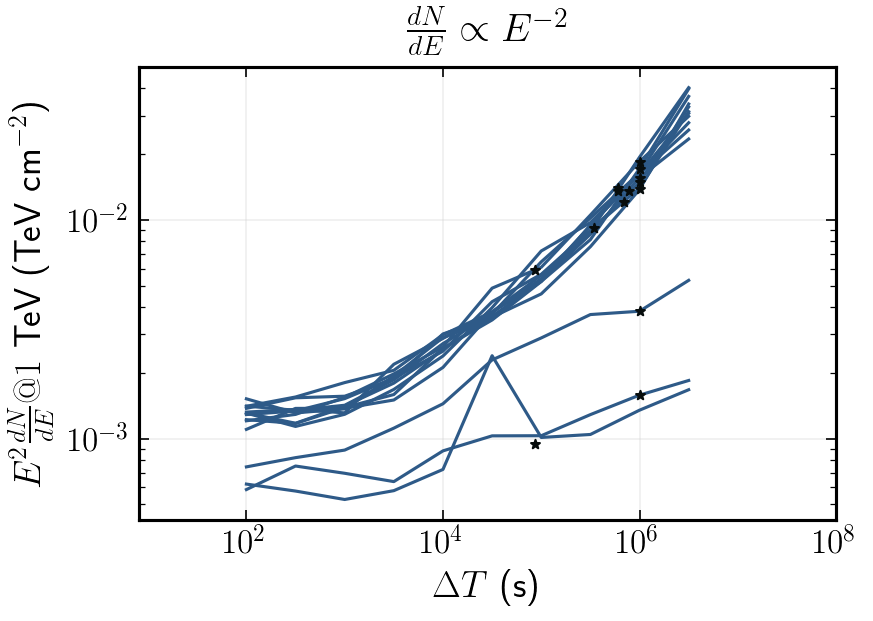

In [40]:
cat.sensitivity_vs_time()

In [15]:
plt.errorbar(results[2.0][0]['info']['n_sigs'], results[2.0][0]['info']['CLs'], yerr= results[2.0][0]['info']['sigmas'])

NameError: name 'results' is not defined

In [18]:
results[2.0][0]

{'n_sig': 7.716186578607563,
 'n_sig_error': 0.0,
 'n_sig_history': array([7.71618658]),
 'n_sig_error_history': array([0.]),
 'n_trials_history': [250],
 'info': {'n_sig': 7.716186578607563,
  'n_sig_chi2cdf': inf,
  'n_sig_spline': 7.716186578607563,
  'dof': 10,
  'loc': 0,
  'scale': 1.00000000002,
  'params': [10, 0, 1.00000000002],
  'spline': <scipy.interpolate._cubic.PchipInterpolator at 0x7f8f9571e170>,
  'n_sigs': array([ 0.,  6., 12., 18., 24., 30.]),
  'CLs': array([0.52 , 0.848, 0.98 , 0.996, 1.   , 1.   ]),
  'sigmas': array([0.03159747, 0.02270647, 0.00885438, 0.00399199, 0.00399199,
         0.00399199]),
  'ts_threshold': 0.00030964141123557276,
  'ts_from_fit': True,
  'ts_nsigma': 0,
  'ts_beta': 0.9},
 'tss': {0.0: array([6.55039482e-03, 3.57948286e-03, 1.41443728e+00, 4.06183762e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         5.15303506e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         4.66122184e-02, 5.82600562e-0

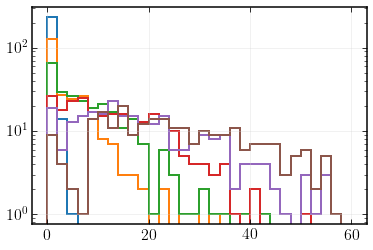

In [25]:
for k, v in results[2.0][0]['tss'].items():
    plt.hist(v, label='ninj {}'.format(k), histtype='step', lw=2., bins=np.linspace(0., 60., 31))
    
plt.yscale('log')
plt.show()

In [4]:
greco_base = '/data/user/apizzuto/Nova/GRECO_Skylab_Dataset/v2.2/'

data_fs = sorted(glob(greco_base + 'IC86_20*data_with_angErr.npy'))
exp = [np.load(data) for data in data_fs]
exp = np.hstack(exp)
mc = np.load(greco_base + 'IC86_2012.numu_with_angErr.npy')
grls = sorted(glob(greco_base + 'GRL/IC86_20*data.npy'))
grl = [np.load(g) for g in grls]
grl = np.hstack(grl)

greco = cy.selections.CustomDataSpecs.CustomDataSpec(exp, mc, np.sum(grl['livetime']), 
                                                     np.linspace(-1., 1., 31),
                                                     np.linspace(0., 4., 31), 
                                                     grl=grl, key='GRECOv2.2', cascades=True)

ana_dir = cy.utils.ensure_dir('/data/user/apizzuto/csky_cache/greco_ana')
greco_ana = cy.get_analysis(cy.selections.repo, greco, dir=ana_dir)

Setting up Analysis for:
GRECOv2.2
Setting up GRECOv2.2...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [5]:
tab = Table.read('/home/apizzuto/Nova/source_list/appendix.tex')
df = tab.to_pandas()
coords = SkyCoord(frame="galactic", l=df['$l$']*u.degree, b=df['$b$']*u.degree)
equatorial = coords.icrs
df['ra'] = equatorial.ra.deg
df['dec'] = equatorial.dec.deg
df['gamma'] = [~np.char.startswith(fl, '$<$') for fl in df['Flux']] 
df = df.replace(['-'], np.nan)
df[u'$t_2$'] = df[u'$t_2$'].astype(float)

In [6]:
max_time_window = 5.
#df = df[~df['gamma']]
df['$t_2$'][np.isnan(df['$t_2$'])] = max_time_window
df['mjd'] = np.array([Time(pt, '%Y-%m-%d').mjd for pt in df['Peak Time']])
during_greco = (df['mjd'] > greco_ana.mjd_min) & (df['mjd'] + df['$t_2$'] < greco_ana.mjd_max)
df = df[during_greco]

/home/apizzuto/.venvs/py3_realtime/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
ras = df['ra']
decs = df['dec']
delta_t = df['$t_2$']
delta_t = np.minimum(delta_t, np.ones_like(delta_t)*max_time_window)

conf = {'extended': True,
       'space': "ps",
        'time': "transient",
        'sig': 'transient',
       }

src = cy.utils.Sources(ra=np.radians(ras), 
                       dec=np.radians(decs), 
                       mjd=df['mjd'], 
                       sigma_t=np.zeros_like(delta_t), 
                       t_100=delta_t)

cy.CONF['src'] = src
cy.CONF['mp_cpus'] = 10

tr = cy.get_trial_runner(conf, ana=greco_ana, src=src)
n_trials = 500
bg = cy.dists.Chi2TSD(tr.get_many_fits(n_trials))

Performing 500 background trials using 10 cores:
        500/500 trials complete.   


## Differential sensitivity

In [26]:
reload(plotting)

<module 'plotting' from '/home/apizzuto/Nova/scripts/plotting.py'>

In [41]:
stack_plots = plotting.StackingPlots(86.4, seed=2, min_log_e=0.0)

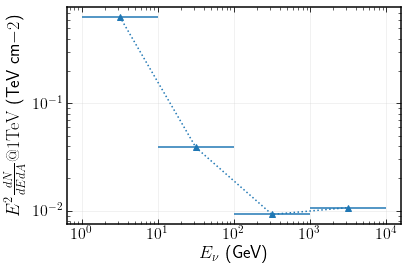

In [42]:
stack_plots.plot_differential_sens()

In [43]:
for en in [1., 10., 100., 1000.]:
    print(stack_plots.diff_sens[f'sensitivity_{en:.1f}_{en*10.:.1f}']['n_sig'])

3.4654520471569286
3.7902103360568318
2.091458192390185
2.695651414253487
